In [1]:
import os
import pandas as pd

ROOT_PATH = '/sources/dataset/'
df = pd.read_csv(os.path.join(ROOT_PATH, 'train.csv'))
landmarks = os.listdir(os.path.join(ROOT_PATH, 'train_landmark_files'))

In [2]:
df.head()

,path,participant_id,sequence_id,sign
0,train_landmark_files/26734/1000035562.parquet,26734,1000035562,blow
1,train_landmark_files/28656/1000106739.parquet,28656,1000106739,wait
2,train_landmark_files/16069/100015657.parquet,16069,100015657,cloud
3,train_landmark_files/25571/1000210073.parquet,25571,1000210073,bird
4,train_landmark_files/62590/1000240708.parquet,62590,1000240708,owie


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94477 entries, 0 to 94476
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   path            94477 non-null  object
 1   participant_id  94477 non-null  int64 
 2   sequence_id     94477 non-null  int64 
 3   sign            94477 non-null  object
dtypes: int64(2), object(2)
memory usage: 2.9+ MB


In [4]:
paths = df.path.values
p_ids = df.participant_id.values
s_ids = df.sequence_id.values
labels = df.sign.values

In [5]:
sample = pd.read_parquet(os.path.join(ROOT_PATH, paths[3]))
sample

,frame,row_id,type,landmark_index,x,y,z
0,17,17-face-0,face,0,0.495870,0.478694,-0.037412
1,17,17-face-1,face,1,0.492222,0.447209,-0.067939
2,17,17-face-2,face,2,0.492067,0.457237,-0.035722
3,17,17-face-3,face,3,0.480419,0.415996,-0.050779
4,17,17-face-4,face,4,0.492035,0.437453,-0.072314
...,...,...,...,...,...,...,...
6511,28,28-right_hand-16,right_hand,16,0.506396,0.868416,-0.139545
6512,28,28-right_hand-17,right_hand,17,0.323227,0.835990,-0.136632
6513,28,28-right_hand-18,right_hand,18,0.435733,0.848917,-0.156200
6514,28,28-right_hand-19,right_hand,19,0.476093,0.867098,-0.149442


In [6]:
import numpy as np

print(np.unique(sample.frame))
print(np.unique(sample.type))

[17 18 19 20 21 22 23 24 25 26 27 28]
['face' 'left_hand' 'pose' 'right_hand']


In [7]:
print('landmark count')
print('# face', len(np.unique(sample[sample.type=='face']['landmark_index'])))
print('# pose', len(np.unique(sample[sample.type=='pose']['landmark_index'])))
print('# lh', len(np.unique(sample[sample.type=='left_hand']['landmark_index'])))
print('# rh', len(np.unique(sample[sample.type=='right_hand']['landmark_index'])))

landmark count
# face 468
# pose 33
# lh 21
# rh 21


In [8]:
for p_id in np.unique(p_ids):
    print(f"p_id: {p_id}, # labels: {len(np.unique(df[df.participant_id==p_id].sign))}, # samples: {len(df[df.participant_id==p_id])}")
    

p_id: 2044, # labels: 250, # samples: 4810
p_id: 4718, # labels: 250, # samples: 3499
p_id: 16069, # labels: 250, # samples: 4848
p_id: 18796, # labels: 250, # samples: 3502
p_id: 22343, # labels: 250, # samples: 4677
p_id: 25571, # labels: 242, # samples: 3865
p_id: 26734, # labels: 250, # samples: 4841
p_id: 27610, # labels: 250, # samples: 4275
p_id: 28656, # labels: 250, # samples: 4563
p_id: 29302, # labels: 250, # samples: 4722
p_id: 30680, # labels: 238, # samples: 3338
p_id: 32319, # labels: 250, # samples: 4753
p_id: 34503, # labels: 250, # samples: 4545
p_id: 36257, # labels: 250, # samples: 4896
p_id: 37055, # labels: 250, # samples: 4648
p_id: 37779, # labels: 250, # samples: 4782
p_id: 49445, # labels: 250, # samples: 4968
p_id: 53618, # labels: 250, # samples: 4656
p_id: 55372, # labels: 250, # samples: 4826
p_id: 61333, # labels: 250, # samples: 4900
p_id: 62590, # labels: 250, # samples: 4563


In [9]:
print("label count")
for p_id in np.unique(p_ids):
    label_cnt = df[df.participant_id==p_id].sign.value_counts()
    print(f'p_id: {p_id}, max: {label_cnt.max()}, min: {label_cnt.min()}, mean: {label_cnt.mean()}')

label count
p_id: 2044, max: 25, min: 3, mean: 19.24
p_id: 4718, max: 20, min: 5, mean: 13.996
p_id: 16069, max: 27, min: 9, mean: 19.392
p_id: 18796, max: 23, min: 3, mean: 14.008
p_id: 22343, max: 22, min: 11, mean: 18.708
p_id: 25571, max: 20, min: 3, mean: 15.97107438016529
p_id: 26734, max: 25, min: 13, mean: 19.364
p_id: 27610, max: 23, min: 4, mean: 17.1
p_id: 28656, max: 26, min: 11, mean: 18.252
p_id: 29302, max: 21, min: 11, mean: 18.888
p_id: 30680, max: 21, min: 1, mean: 14.025210084033613
p_id: 32319, max: 22, min: 14, mean: 19.012
p_id: 34503, max: 22, min: 11, mean: 18.18
p_id: 36257, max: 28, min: 11, mean: 19.584
p_id: 37055, max: 28, min: 5, mean: 18.592
p_id: 37779, max: 24, min: 9, mean: 19.128
p_id: 49445, max: 32, min: 12, mean: 19.872
p_id: 53618, max: 29, min: 11, mean: 18.624
p_id: 55372, max: 29, min: 12, mean: 19.304
p_id: 61333, max: 23, min: 15, mean: 19.6
p_id: 62590, max: 23, min: 11, mean: 18.252


## Save info

In [10]:
# from tqdm import tqdm
# # test_df = df.iloc[:10]
# feat_df = []
# for item in tqdm(df.itertuples()):
#     path, p_id, s_id, label = item.path, item.participant_id, item.sequence_id, item.sign
#     sample = pd.read_parquet(os.path.join(ROOT_PATH, path))
    
#     frames = np.unique(sample.frame)
#     start_frame = min(frames)
#     end_frame = max(frames)
#     total_frames = end_frame - start_frame + 1

#     length = len(sample)

#     tmp = pd.DataFrame([[start_frame, end_frame, total_frames, length]], columns=['start_frame', 'end_frame', 'total_frames', 'length'], dtype=int)
#     feat_df.append(tmp)

In [11]:
# feat_df = pd.concat(feat_df, ignore_index=True)
# new_df = pd.concat([df, feat_df], axis=1)

In [12]:
# new_df.to_csv(os.path.join(ROOT_PATH, 'train_w_duration.csv'))

In [13]:
# new_df = pd.read_csv(os.path.join(ROOT_PATH, 'train_w_duration.csv'))

# new_df_indexed = new_df.set_index('sign')
# from collections import defaultdict

# info = defaultdict()
# percentile = [0, 1, 5, 25, 50, 75, 95, 99, 100]
# for s in labels:
#     tmp = new_df_indexed.loc[s]
#     p_start_frame = list(map(int, np.percentile(tmp.start_frame, percentile, method='nearest')))
#     p_end_frame = list(map(int, np.percentile(tmp.end_frame, percentile, method='nearest')))
#     p_total_frames = list(map(int, np.percentile(tmp.total_frames, percentile, method='nearest')))
#     p_length = list(map(int, np.percentile(tmp.length, percentile, method='nearest')))

#     min_start_frame, max_start_frame, mean_start_frame, std_start_frame = p_start_frame[0], p_start_frame[-1], int(np.mean(tmp.start_frame)), int(np.std(tmp.start_frame))
#     min_end_frame, max_end_frame, mean_end_frame, std_end_frame = p_end_frame[0], p_end_frame[-1], int(np.mean(tmp.end_frame)), int(np.std(tmp.end_frame))
#     min_total_frames, max_total_frames, mean_total_frames, std_total_frames = p_total_frames[0], p_total_frames[-1], int(np.mean(tmp.total_frames)), int(np.std(tmp.total_frames))
#     min_length, max_length, mean_length, std_length = p_length[0], p_length[-1], int(np.mean(tmp.length)), int(np.std(tmp.length))

#     info[s] = {'start_frame': {'min': min_start_frame, 'max': max_start_frame, 'mean': mean_start_frame, 'std': std_start_frame, 'percent (0, 1, 5, 25, 50, 75, 95, 99, 100)': p_start_frame}, \
#                 'end_frame': {'min': min_end_frame, 'max': max_end_frame, 'mean': mean_end_frame, 'std': std_end_frame, 'percent (0, 1, 5, 25, 50, 75, 95, 99, 100)': p_end_frame}, \
#                 'total_frames': {'min': min_total_frames, 'max': max_total_frames, 'mean': mean_total_frames, 'std': std_total_frames, 'percent (0, 1, 5, 25, 50, 75, 95, 99, 100)': p_total_frames}, \
#                 'length': {'min': min_length, 'max': max_length, 'mean': mean_length, 'std': std_length, 'percent (0, 1, 5, 25, 50, 75, 95, 99, 100)': p_length}}
    
    

In [14]:
# import json

# with open(os.path.join(ROOT_PATH, "sign_info.json"), "w") as outfile:
#     json.dump(info, outfile, indent=4)


### Hand landmark index

In [15]:
rhand_sample = sample.loc[(sample.type=='right_hand') & (sample.frame==25)]
rhand_sample

,frame,row_id,type,landmark_index,x,y,z
4866,25,25-right_hand-0,right_hand,0,0.251491,0.726240,1.808960e-07
4867,25,25-right_hand-1,right_hand,1,0.340424,0.702110,4.496143e-04
4868,25,25-right_hand-2,right_hand,2,0.401020,0.665496,-9.757900e-03
4869,25,25-right_hand-3,right_hand,3,0.445567,0.640143,-2.567013e-02
4870,25,25-right_hand-4,right_hand,4,0.481659,0.617956,-4.017856e-02
4871,25,25-right_hand-5,right_hand,5,0.353002,0.587445,-1.010126e-02
4872,25,25-right_hand-6,right_hand,6,0.450735,0.587257,-4.291311e-02
4873,25,25-right_hand-7,right_hand,7,0.504127,0.609723,-6.672095e-02
4874,25,25-right_hand-8,right_hand,8,0.534281,0.633028,-7.961111e-02
4875,25,25-right_hand-9,right_hand,9,0.337375,0.596101,-2.519550e-02


In [16]:
RHAND_X, RHAND_Y, RHAND_Z = np.array(rhand_sample.x), np.array(rhand_sample.y), np.array(rhand_sample.z)

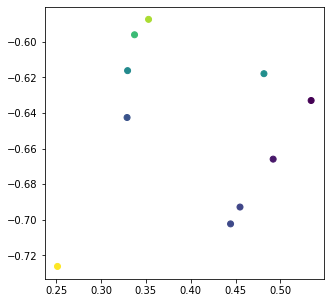

In [17]:
simple_hand = [0, 4, 5, 8, 9, 12, 13, 16, 17, 20]
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot()
ax.scatter(RHAND_X[simple_hand], -RHAND_Y[simple_hand], c=RHAND_Z[simple_hand])
plt.show()

In [18]:
wrist = np.array(rhand_sample.iloc[0][['x', 'y','z']], dtype=np.float32)
rhand5 = np.array(rhand_sample.iloc[5][['x', 'y','z']], dtype=np.float32)
rhand17 = np.array(rhand_sample.iloc[17][['x', 'y','z']], dtype=np.float32)

a = rhand17 - wrist
b = rhand5 - wrist
print(a, b)

[ 0.07756501 -0.08366305 -0.05913687] [ 0.10151052 -0.1387952  -0.01010144]


In [19]:
np.cross(a, b)
np.linalg.norm(np.cross(a, b))
print(np.cross(a, b), np.linalg.norm(np.cross(a, b)))

[-0.0073628  -0.0052195  -0.00227297] 0.009307004


In [20]:
upnv = np.cross(a, b) / np.linalg.norm(np.cross(a, b))
print(upnv, np.linalg.norm(upnv))

[-0.7911027  -0.56081384 -0.24422166] 0.99999994


### Face landmark index

In [21]:
sample.loc[sample.frame==25]

,frame,row_id,type,landmark_index,x,y,z
4344,25,25-face-0,face,0,0.466060,0.513062,-0.035248
4345,25,25-face-1,face,1,0.468185,0.480932,-0.070208
4346,25,25-face-2,face,2,0.469665,0.489645,-0.035517
4347,25,25-face-3,face,3,0.454098,0.447533,-0.053366
4348,25,25-face-4,face,4,0.467143,0.470970,-0.075338
...,...,...,...,...,...,...,...
4882,25,25-right_hand-16,right_hand,16,0.454963,0.692872,-0.062859
4883,25,25-right_hand-17,right_hand,17,0.329056,0.642577,-0.059137
4884,25,25-right_hand-18,right_hand,18,0.414907,0.656046,-0.075521
4885,25,25-right_hand-19,right_hand,19,0.438455,0.681077,-0.070357


In [22]:
face_sample = sample.loc[(sample.type=='face') & (sample.frame==25)]
face_sample

,frame,row_id,type,landmark_index,x,y,z
4344,25,25-face-0,face,0,0.466060,0.513062,-0.035248
4345,25,25-face-1,face,1,0.468185,0.480932,-0.070208
4346,25,25-face-2,face,2,0.469665,0.489645,-0.035517
4347,25,25-face-3,face,3,0.454098,0.447533,-0.053366
4348,25,25-face-4,face,4,0.467143,0.470970,-0.075338
...,...,...,...,...,...,...,...
4807,25,25-face-463,face,463,0.502547,0.419255,0.004809
4808,25,25-face-464,face,464,0.495073,0.421414,-0.002611
4809,25,25-face-465,face,465,0.490066,0.422928,-0.011167
4810,25,25-face-466,face,466,0.563937,0.415143,0.009513


In [23]:
FACE_X, FACE_Y, FACE_Z = np.array(face_sample.x), np.array(face_sample.y), np.array(face_sample.z)

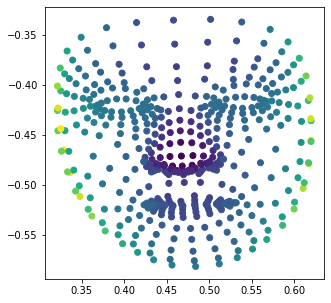

In [24]:
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot()
ax.scatter(FACE_X[1:], -FACE_Y[1:], c=FACE_Z[1:])
plt.show()

In [28]:
FACE_LM = [10, 338, 297, 332, 284, 251, 389, 356, 454, 323, 361, 288, 397, 365, 379, 378, 400, 377, 152, 148, 176, 149, 150, 136, 172, 58, 132, 93, 234, 127, 162, 21, 54, 103, 67, 109]
LEYE_LM = [130, 247, 30, 29, 27, 28, 56, 190, 243, 112, 26, 22, 23, 24, 110, 25]
REYE_LM = [359, 467, 260, 259, 257, 258, 286, 414, 463, 341, 256, 252, 253, 254, 339, 255]
NOSE_LM = [6, 197, 195, 5, 4, 1, 19, 94, 2, 164, 49, 102, 64, 279, 331, 294]
LIPSOUT_LM = [0, 267, 269, 270, 409, 287, 375, 321, 405, 314, 17, 84, 181, 91, 146, 57, 185, 40, 39, 37]
LIPSIN_LM = [13, 312, 311, 310, 415, 308, 324, 318, 402, 317, 14, 87, 178, 88, 95, 78, 191, 80, 81, 82]
SPECIAL_LM = [9, 123, 36, 50, 352, 280, 266, 199, 200]
FACE_SELECTED = []
# SELECTED.extend(FACE_LM)
# SELECTED.extend(LEYE_LM)
# SELECTED.extend(REYE_LM)
# SELECTED.extend(NOSE_LM)
# FACE_SELECTED.extend(LIPSOUT_LM)
# FACE_SELECTED.extend(LIPSIN_LM)
# SELECTED.extend(SPECIAL_LM)
LIP = [
        61,
        185,
        40,
        39,
        37,
        0,
        267,
        269,
        270,
        409,
        291,
        146,
        91,
        181,
        84,
        17,
        314,
        405,
        321,
        375,
        78,
        191,
        80,
        81,
        82,
        13,
        312,
        311,
        310,
        415,
        95,
        88,
        178,
        87,
        14,
        317,
        402,
        318,
        324,
        308,
    ]

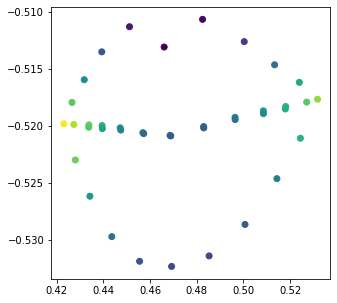

In [29]:
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot()
ax.scatter(FACE_X[LIP], -FACE_Y[LIP], c=FACE_Z[LIP])
plt.show()

(40, 3)
(1, 40, 3)


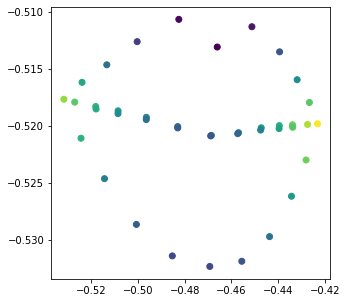

In [31]:

from matplotlib import pyplot as plt
import sys
sys.path.append('/sources')
from transforms import flip_x_lip

lip = np.concatenate((np.expand_dims(FACE_X[LIP], -1), np.expand_dims(FACE_Y[LIP], -1), np.expand_dims(FACE_Z[LIP], -1)), axis=-1)
print(lip.shape)
flip_lip = flip_x_lip(np.expand_dims(lip, 0))
print(flip_lip.shape)
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot()
ax.scatter(flip_lip[...,0], -flip_lip[...,1], c=flip_lip[...,2])
plt.show()

### Pose landmark index

In [35]:
pose_sample = sample.loc[(sample.type=='pose') & (sample.frame==20)]
pose_sample

,frame,row_id,type,landmark_index,x,y,z
2118,20,20-pose-0,pose,0,0.471716,0.436606,-1.600365
2119,20,20-pose-1,pose,1,0.520546,0.388495,-1.526905
2120,20,20-pose-2,pose,2,0.548639,0.390261,-1.526759
2121,20,20-pose-3,pose,3,0.571596,0.393736,-1.527164
2122,20,20-pose-4,pose,4,0.438571,0.391594,-1.515198
2123,20,20-pose-5,pose,5,0.415772,0.393339,-1.514956
2124,20,20-pose-6,pose,6,0.397467,0.395537,-1.515186
2125,20,20-pose-7,pose,7,0.609715,0.423951,-0.985130
2126,20,20-pose-8,pose,8,0.372314,0.420456,-0.884346
2127,20,20-pose-9,pose,9,0.530895,0.488386,-1.395316


In [36]:
POSE_X, POSE_Y, POSE_Z = np.array(pose_sample.x), np.array(pose_sample.y), np.array(pose_sample.z)

In [48]:
PNOSE_LM = [0]
PFACE_LM = [8, 6, 5, 4, 1,2,3,7]
BODY_LM = [11, 12, 24 ,23]
ARM_LM = [14, 16, 22, 20, 18, 13, 15, 21, 19, 17]

POSE_SELECTED = []
# POSE_SELECTED.extend(PNOSE_LM)
# POSE_SELECTED.extend(PFACE_LM)
POSE_SELECTED.extend(BODY_LM)
# POSE_SELECTED.extend(ARM_LM)
simple_pose = [0, 1, 4, 11, 12, 13, 14]
POSE_SIM = [489 +i for i in simple_pose]

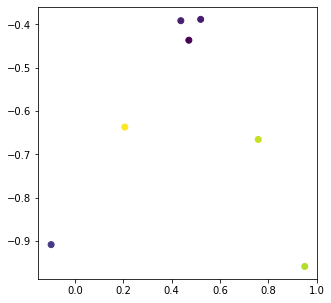

In [49]:
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot()
ax.scatter(POSE_X[simple_pose], -POSE_Y[simple_pose], c=POSE_Z[simple_pose])
plt.show()

### Overall landmark

In [60]:
sample

,frame,row_id,type,landmark_index,x,y,z
0,17,17-face-0,face,0,0.495870,0.478694,-0.037412
1,17,17-face-1,face,1,0.492222,0.447209,-0.067939
2,17,17-face-2,face,2,0.492067,0.457237,-0.035722
3,17,17-face-3,face,3,0.480419,0.415996,-0.050779
4,17,17-face-4,face,4,0.492035,0.437453,-0.072314
...,...,...,...,...,...,...,...
6511,28,28-right_hand-16,right_hand,16,0.506396,0.868416,-0.139545
6512,28,28-right_hand-17,right_hand,17,0.323227,0.835990,-0.136632
6513,28,28-right_hand-18,right_hand,18,0.435733,0.848917,-0.156200
6514,28,28-right_hand-19,right_hand,19,0.476093,0.867098,-0.149442


In [65]:
overall_sample = sample[sample.frame==28]
overall_sample

,frame,row_id,type,landmark_index,x,y,z
5973,28,28-face-0,face,0,0.475503,0.520668,-0.033753
5974,28,28-face-1,face,1,0.481996,0.492690,-0.070461
5975,28,28-face-2,face,2,0.483007,0.500925,-0.035868
5976,28,28-face-3,face,3,0.469551,0.458163,-0.054357
5977,28,28-face-4,face,4,0.481326,0.482237,-0.075616
...,...,...,...,...,...,...,...
6511,28,28-right_hand-16,right_hand,16,0.506396,0.868416,-0.139545
6512,28,28-right_hand-17,right_hand,17,0.323227,0.835990,-0.136632
6513,28,28-right_hand-18,right_hand,18,0.435733,0.848917,-0.156200
6514,28,28-right_hand-19,right_hand,19,0.476093,0.867098,-0.149442


In [66]:
X, Y, Z = np.array(overall_sample.x), np.array(overall_sample.y), np.array(overall_sample.z)

In [67]:
LH_OFFSET = 468
LHAND = [LH_OFFSET + i for i in range(21)]
RH_OFFSET = 522
RHAND = [RH_OFFSET + i for i in range(21)]
simple_pose = [0, 1, 4, 11, 12, 13, 14, 15, 16]
POSE_SIM = [489 + i for i in simple_pose]
SLIP = [
    78,
    95,
    88,
    178,
    87,
    14,
    317,
    402,
    318,
    324,
    308,
    191,
    80,
    81,
    82,
    13,
    312,
    311,
    310,
    415,
]
selected = LHAND + RHAND + SLIP +POSE_SIM 

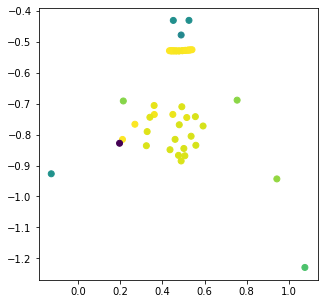

In [68]:
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot()
ax.scatter(X[selected], -Y[selected], c=Z[selected])
plt.show()